# Fase de **Entrenamiento y validación** | Verne Academy **Kaggle Competition**
### Por **Mario Jurado Galán**
Este notebook incluye:  
+ Carga de datos
+ EDA
+ Transformaciones
+ Entrenamiento del modelo y predicción
+ Evaluación y visualización de resultados
+ Interpretabilidad


# 0. Librerias

In [ ]:
# ----Tratamiento de datos---
import functions as func
import pandas as pd
pd.set_option("display.max_rows", None)

# ----Modelado del dataset----
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from category_encoders import TargetEncoder
from sklearn.feature_selection import RFECV

# ----Modelo y entrenamiento----
import optuna
from sklearn.model_selection import train_test_split
import lightgbm as lgbm


# ----Metricas y visualización de gráficos----
from sklearn.metrics import classification_report, confusion_matrix, auc, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import shap
shap.initjs()

# ----Warnings----
import warnings
warnings.filterwarnings('once')  


C:\Users\SumeriO\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### -> Optimizar hiperparametros y mejores variables?

In [ ]:
# Variable a modificar si se quiere realizar una busqueda de los mejores hiperparametros y de las mejores variables a utilizar o usar las ya existentes.
realizar_tuneo_HP_y_RFECV=False

# 1. Carga de datos
+ Carga del dataset en memoria

In [3]:
dataset_df=pd.read_csv("../Datasets/MasterBI_Train.csv")

C:\Users\SumeriO\AppData\Local\Temp\ipykernel_20816\158176516.py:1: DtypeWarning: Columns (28) have mixed types. Specify dtype option on import or set low_memory=False.
  dataset_df=pd.read_csv("../Datasets/MasterBI_Train.csv")


# 2. EDA
En esta sección se hará un analisis sobre los datos para ver que los componen, como tipos de datos, existencia de nulos y valores únicos, además de comprobar si se necesita Imbalance Learning.  

### Información sobre los datos

In [4]:
print(f"--Train dataset--\nRows:{dataset_df.shape[0]}\nColumns:{dataset_df.shape[1]}")

--Train dataset--
Rows:892148
Columns:83


In [5]:
dataset_df.head(10)

,MachineIdentifier,ProductName,EngineVersion,AppVersion,AvSigVersion,IsBeta,RtpStateBitfield,IsSxsPassiveMode,DefaultBrowsersIdentifier,AVProductStatesIdentifier,...,Census_FirmwareVersionIdentifier,Census_IsSecureBootEnabled,Census_IsWIMBootEnabled,Census_IsVirtualDevice,Census_IsTouchEnabled,Census_IsPenCapable,Census_IsAlwaysOnAlwaysConnectedCapable,Wdft_IsGamer,Wdft_RegionIdentifier,HasDetections
0,7bd132f88d90f8c628ae7204ce1e0038,win8defender,1.1.15100.1,4.18.1807.18075,1.273.1486.0,0,7.0,0,NaN,53447.0,...,12300.0,1,NaN,0.0,0,0,0.0,0.0,6.0,1
1,12678cb674ee9f2c85e526dc9774845d,win8defender,1.1.15100.1,4.18.1807.18075,1.273.1234.0,0,7.0,0,NaN,53447.0,...,70187.0,0,NaN,0.0,0,0,0.0,1.0,4.0,0
2,624400f847781fe7ccc3546e921fb46f,win8defender,1.1.15000.2,4.18.1806.18062,1.271.545.0,0,7.0,0,NaN,53447.0,...,13909.0,1,0.0,0.0,0,0,0.0,0.0,10.0,1
3,5dd6c5c23e09214f43fbe89888bf98f7,win8defender,1.1.15100.1,4.11.15063.0,1.273.912.0,0,7.0,0,NaN,53447.0,...,33319.0,0,NaN,0.0,0,0,0.0,1.0,10.0,1
4,5d601bdcff9df13a981c468325429ba0,win8defender,1.1.15200.1,4.18.1807.18075,1.275.1318.0,0,7.0,0,NaN,53447.0,...,70290.0,1,NaN,0.0,0,0,0.0,1.0,15.0,0
5,adc6e41cee2ae561c1942926a4b86f3f,win8defender,1.1.15200.1,4.18.1807.18075,1.275.697.0,0,7.0,0,NaN,7945.0,...,33165.0,1,NaN,0.0,0,0,0.0,0.0,10.0,0
6,420f0de9b1af3f6a00c9cf7610d08f0e,win8defender,1.1.15100.1,4.14.17639.18041,1.273.692.0,0,7.0,0,NaN,53447.0,...,70299.0,1,0.0,0.0,0,0,0.0,1.0,11.0,1
7,d741f09bbcdd041f1cfe72f069b83b3e,win8defender,1.1.14901.4,4.14.17639.18041,1.269.272.0,0,7.0,0,NaN,62773.0,...,11778.0,1,0.0,0.0,0,0,0.0,0.0,10.0,1
8,d543a3ef8787c0222b456ac50e755582,win8defender,1.1.15100.1,4.16.17656.18052,1.273.810.0,0,7.0,0,NaN,7945.0,...,69919.0,1,NaN,0.0,0,0,0.0,0.0,11.0,1
9,8abea91ba204f59a67a95729bb1300dd,win8defender,1.1.15200.1,4.18.1807.18075,1.275.727.0,0,7.0,0,NaN,53447.0,...,19970.0,1,0.0,0.0,0,0,0.0,1.0,3.0,1


In [6]:
dataset_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 892148 entries, 0 to 892147
Data columns (total 83 columns):
 #   Column                                             Non-Null Count   Dtype  
---  ------                                             --------------   -----  
 0   MachineIdentifier                                  892148 non-null  object 
 1   ProductName                                        892148 non-null  object 
 2   EngineVersion                                      892148 non-null  object 
 3   AppVersion                                         892148 non-null  object 
 4   AvSigVersion                                       892148 non-null  object 
 5   IsBeta                                             892148 non-null  int64  
 6   RtpStateBitfield                                   888846 non-null  float64
 7   IsSxsPassiveMode                                   892148 non-null  int64  
 8   DefaultBrowsersIdentifier                          43369 non-null   float6

In [7]:
print("---Nulls count---")
dataset_df.isna().sum().sum()

---Nulls count---


6070297

In [8]:
print("--Uniques count--")
dataset_df.nunique()

--Uniques count--


MachineIdentifier                                    892148
ProductName                                               5
EngineVersion                                            55
AppVersion                                               95
AvSigVersion                                           7242
IsBeta                                                    2
RtpStateBitfield                                          7
IsSxsPassiveMode                                          2
DefaultBrowsersIdentifier                               719
AVProductStatesIdentifier                              7546
AVProductsInstalled                                       6
AVProductsEnabled                                         6
HasTpm                                                    2
CountryIdentifier                                       222
CityIdentifier                                        48331
OrganizationIdentifier                                   44
GeoNameIdentifier                       

In [ ]:
# Identificación del id y el label
id="MachineIdentifier"
label="HasDetections"

In [11]:
# Comprobar si se necesita imbalance learning
dataset_df[label].value_counts(normalize=True)

HasDetections
0    0.500207
1    0.499793
Name: proportion, dtype: float64

# 3. Transformaciones
+ Eliminación del Id
+ Selección de variables - Metodo manual
+ Transformación manual de valores y tipos de datos
+ Creacion de variables de máscara y contextuales
+ División de los datos en train y test
+ Imputación de nulos 
    + Simple Imputer (por la media para valores numéricos y valor mas frecuente para valores categoricos)
+ Aplicación de encoders
    + OneHot Encoder (variables con 5 o menos valores únicos)
    + Target Encoder (variables con mas de 5 valores únicos)
+ Tuneo de hiperparametros
+ Selección de variables con RFECV

In [10]:
# Eliminación del ID por no aportar ningun valor al entrenamiento
dataset_df=dataset_df.drop(columns=id)

### Selección de variables - Metodo manual

In [12]:
print("---Top variables por porcentaje de nulos del total---")
stats = []
for col in dataset_df.columns:
    stats.append((col, dataset_df[col].nunique(), dataset_df[col].isna().sum() * 100 / dataset_df.shape[0], 
                dataset_df[col].value_counts(normalize=True, dropna=False).values[0] * 100, dataset_df[col].dtype))

stats_df = pd.DataFrame(stats, columns=['Feature', 
                                        'Unique_values', 
                                        'Percentage of missing values', 
                                        'Percentage of values in the biggest category', 
                                        'type'])

stats_df.sort_values('Percentage of missing values', ascending=False).head(20)


---Top variables por porcentaje de nulos del total---


,Feature,Unique_values,Percentage of missing values,Percentage of values in the biggest category,type
27,PuaMode,1,99.975004,99.975004,object
40,Census_ProcessorClass,3,99.581796,99.581796,object
7,DefaultBrowsersIdentifier,719,95.138811,95.138811,float64
67,Census_IsFlightingInternal,2,83.063460,83.063460,float64
51,Census_InternalBatteryType,37,71.062985,71.062985,object
70,Census_ThresholdOptIn,2,63.539345,63.539345,float64
74,Census_IsWIMBootEnabled,1,63.455615,63.455615,float64
30,SmartScreen,11,35.572797,48.387151,object
14,OrganizationIdentifier,44,30.885346,46.970794,float64
28,SMode,2,6.030165,93.923542,float64


In [13]:
# Se borrarán columnas con una cantidad de nulos mayor al 90%, que sean constantes, ids o que sean totalmente irrelevantes para el modelo.
delete_features=["PuaMode","Census_ProcessorClass","DefaultBrowsersIdentifier","Census_IsFlightingInternal","Census_InternalBatteryType",
                                "Census_ThresholdOptIn","SmartScreen","OrganizationIdentifier"]
dataset_df=dataset_df[[col for col in dataset_df.columns if col not in delete_features]]

### Transformaciones manuales

In [14]:
# La columna Census_IsWIMBootEnabled tiene un 36% de 0 y un 63% de valores nulos, a juzgar por el nombre, podemos suponer que el nulo equivale al valor 1
dataset_df["Census_IsWIMBootEnabled"]=dataset_df["Census_IsWIMBootEnabled"].fillna(1.0)

In [ ]:
# Las siguientes columnas tienen nulos y son numeros pero deberian ser tratadas como categorias en vez de numericas, para imputarse por el valor mas frecuente.
new_cat_cols=["CountryIdentifier","CityIdentifier","GeoNameIdentifier","AVProductStatesIdentifier","AVProductsInstalled","AVProductsEnabled","IsProtected","SMode",
            "IeVerIdentifier","Firewall","Census_OEMNameIdentifier","Census_OEMModelIdentifier","Census_ProcessorCoreCount","Census_ProcessorManufacturerIdentifier",
            "Census_ProcessorModelIdentifier","Census_TotalPhysicalRAM","Census_OSInstallLanguageIdentifier","Census_IsFlightsDisabled",
            "Census_FirmwareManufacturerIdentifier","Census_FirmwareVersionIdentifier","Census_IsVirtualDevice","Census_IsAlwaysOnAlwaysConnectedCapable","Wdft_IsGamer","Wdft_RegionIdentifier"] 
dataset_df[new_cat_cols]=dataset_df[new_cat_cols].astype("category")

### Creación de variables de máscara y contextuales sintéticas 
+ Para las variables del estilo máscara de red, se creará una columna con cada division posible de esa máscara.
+ Se creará una columna con el valor medio, el máximo y el mínimo por cada una de las combinaciones posibles entre columnas categoricas y numericas indicadas a continuación.

In [ ]:
# Creación de variables de máscara
dataset_df=func.add_mask_features(dataset_df)

In [ ]:
# Variables elegidas por ser de las más relevantes en las primeras iteraciones, sin añadir ninguna variable extra. 
synth_cat_cols=["CityIdentifier","AVProductStatesIdentifier"]
synth_num_cols=["Census_SystemVolumeTotalCapacity","Census_PrimaryDiskTotalCapacity"]

In [ ]:
# Creación de variables contextuales
dataset_df, added_cols = func.generate_grouped_stats(dataset_df, synth_num_cols, synth_cat_cols)
dataset_df = func.generate_synthetic_features(dataset_df, added_cols)

c:\Users\SumeriO\Desktop\Master BI IA\TFM IA\Fase 2\functions.py:25: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  group_by_feat = df_ext.groupby(by=[cat])
c:\Users\SumeriO\Desktop\Master BI IA\TFM IA\Fase 2\functions.py:31: FutureWarning: The provided callable <function mean at 0x0000012A38D180E0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  df_grouped = group_by_feat[num_feat].agg([np.mean, np.max, np.min]).reset_index()
c:\Users\SumeriO\Desktop\Master BI IA\TFM IA\Fase 2\functions.py:31: FutureWarning: The provided callable <function max at 0x0000012A38D136A0> is currently using SeriesGroupBy.max. In a future version of pandas, the provided callable will be used direc

In [19]:
print(f"--Train dataset--\nRows:{dataset_df.shape[0]}\nColumns:{dataset_df.shape[1]}\n")
print(f"Cantidad de nulos: \nTrain: {dataset_df.isna().sum().sum()}")

--Train dataset--
Rows:892148
Columns:119

Cantidad de nulos: 
Train: 822492


### División del dataset en train y test
+ Se dividiran los datos en una proporcion de 80% para la parte de entrenamiento y un 20% para la parte de pruebas
+ Se utilizá una semilla para lograr siempre la misma división de los datos

In [20]:
# Division en train y test
X_train, X_test, y_train, y_test=train_test_split(
                                        dataset_df.drop(columns=label),
                                        dataset_df[label],
                                        test_size=0.2,
                                        random_state=411)


### Imputación de nulos
+ División de las columnas por tipo de dato
+ Imputación de nulos de variables numericas por la media de ellas
+ Imputación de nulos de variables categoricas por el valor mas frecuente

In [21]:
# Se devuelve columna a su estado numerico original
X_train["Census_PrimaryDiskTotalCapacity"]=X_train["Census_PrimaryDiskTotalCapacity"].astype("category")

In [22]:
# División por tipo de dato
numeric_cols=X_train.select_dtypes(include=["int64","float64"]).columns.to_list()
category_cols=X_train.select_dtypes(include=["category","object"]).columns.to_list()

In [23]:
# Imputar variables numericas por la media 
numeric_imputer=SimpleImputer(strategy="mean")
X_train[numeric_cols]=numeric_imputer.fit_transform(X_train[numeric_cols])
X_test[numeric_cols]=numeric_imputer.transform(X_test[numeric_cols])

In [24]:
# Imputar variables categoricas por el valor mas frecuente
category_imputer=SimpleImputer(strategy="most_frequent")
X_train[category_cols]=category_imputer.fit_transform(X_train[category_cols])
X_test[category_cols]=category_imputer.transform(X_test[category_cols])

### Category Encoders
+ Encoding de variables por cantidad de valores unicos que presentan:
    + OneHotEncoder para columnas con 5 o menos valores unicos
    + TargetEncoder para columnas con más de 5 valores unicos

In [25]:
# Separar las columnas por la cantidad de valores unicos para usar en cada encoder
onehot_cols=list(filter(lambda col:X_train[col].nunique()<=5,X_train.columns))
target_cols=list(filter(lambda col:X_train[col].nunique()>5,X_train.columns))

##### -> OneHot Encoding

In [26]:
# OneHot encoding para variables con pocos valores unicos (<=5)
onehot=OneHotEncoder(handle_unknown='ignore')

train_onehot_encoded=onehot.fit_transform(X_train[onehot_cols])
test_onehot_encoded=onehot.transform(X_test[onehot_cols])

train_onehot_df=pd.DataFrame(data=train_onehot_encoded.toarray(), columns=onehot.get_feature_names_out(onehot_cols),index=X_train.index)
test_onehot_df=pd.DataFrame(data=test_onehot_encoded.toarray(), columns=onehot.get_feature_names_out(onehot_cols),index=X_test.index)

##### -> Target Encoding

In [27]:
# Target encoding para variables con más valores unicos (>5)
target=TargetEncoder()

train_target_df=target.fit_transform(X_train[target_cols].astype("category"), y_train)
test_target_df=target.transform(X_test[target_cols].astype("category"))

In [ ]:
# Fusión de los DataFrames resultantes de los encoders 
X_train=train_onehot_df.join(train_target_df)
X_test=test_onehot_df.join(test_target_df)

In [29]:
print(f"--Train dataset--\nRows:{X_train.shape[0]}\nColumns:{X_train.shape[1]}\n\n--Test dataset--\nRows:{X_test.shape[0]}\nColumns:{X_test.shape[1]}\n")
print(f"Cantidad de nulos: \nTrain: {X_train.isna().sum().sum()}\nTest: {X_test.isna().sum().sum()}")

--Train dataset--
Rows:713718
Columns:162

--Test dataset--
Rows:178430
Columns:162

Cantidad de nulos: 
Train: 0
Test: 0


### Tuneo de hiperparametros
+ Optimización bayesiana con Optuna

In [ ]:
if realizar_tuneo_HP_y_RFECV:

    # Crear el estudio con Optuna buscando maximizar la metrica
    study = optuna.create_study(direction='maximize')
    study.optimize(lambda trial: func.objective(trial, X_train, y_train), n_trials=50)

    best_params = study.best_params
    
else:
    
    # Resultado de último tuneo de hiperparametros con Optuna
    best_params={'n_estimators': 95,
        'feature_fraction': 0.1,
        'bagging_fraction': 0.65,
        'num_leaves': 60,
        'learning_rate': 0.26,
        'max_depth': 75,
        'min_child_samples': 2,
        'reg_alpha': 0.2,
        'reg_lambda': 0.4,
        'colsample_bytree': 0.2}

[I 2024-12-04 23:50:00,325] A new study created in memory with name: no-name-43d4d4c4-3b05-4ed4-aef7-38877d6624e8
C:\Users\SumeriO\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\optuna\distributions.py:693: UserWarning: The distribution is specified by [0.5, 0.99] and step=0.05, but the range is not divisible by `step`. It will be replaced by [0.5, 0.95].
  warnings.warn(
C:\Users\SumeriO\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\optuna\distributions.py:693: UserWarning: The distribution is specified by [0.01, 0.5] and step=0.05, but the range is not divisible by `step`. It will be replaced by [0.01, 0.46].
  warnings.warn(
[I 2024-12-04 23:50:23,154] Trial 0 finished with value: 0.7588794176486677 and parameters: {'n_estimators': 65, 'feature_fraction': 0.6, 'bagging_fraction': 0.65, 'num_leaves': 60, 'learning_rate': 0.01, 'max

Mejores parámetros encontrados: {'n_estimators': 95, 'feature_fraction': 0.1, 'bagging_fraction': 0.65, 'num_leaves': 60, 'learning_rate': 0.26, 'max_depth': 75, 'min_child_samples': 2, 'reg_alpha': 0.2, 'reg_lambda': 0.4, 'colsample_bytree': 0.2}


### Selección de variables - Metodo RFE

In [ ]:
if realizar_tuneo_HP_y_RFECV:
    
    # Selección de variables usando RFECV, buscando maximizar la metrica Recall, con los hiperparametros previamente sacados
    rfe = RFECV(
        estimator=lgbm.LGBMClassifier(**best_params),
        min_features_to_select=10, 
        cv=5, 
        scoring='recall')
    
    rfe.fit(X_train,y_train)
    
    rfe_features=X_train.columns[rfe.support_]

else:
    # Resultado de ultimo RFECV
    rfe_features=['IsSxsPassiveMode_0.0',
        'IsSxsPassiveMode_1.0',
        'HasTpm_0.0',
        'HasTpm_1.0',
        'Platform_windows10',
        'Platform_windows2016',
        'Platform_windows7',
        'Platform_windows8',
        'Processor_arm64',
        'Processor_x64',
        'Processor_x86',
        'IsProtected_0.0',
        'IsProtected_1.0',
        'AutoSampleOptIn_0.0',
        'AutoSampleOptIn_1.0',
        'SMode_0.0',
        'SMode_1.0',
        'Firewall_0.0',
        'Firewall_1.0',
        'Census_DeviceFamily_Windows',
        'Census_DeviceFamily_Windows.Desktop',
        'Census_DeviceFamily_Windows.Server',
        'Census_ProcessorManufacturerIdentifier_1.0',
        'Census_ProcessorManufacturerIdentifier_3.0',
        'Census_ProcessorManufacturerIdentifier_5.0',
        'Census_ProcessorManufacturerIdentifier_10.0',
        'Census_PrimaryDiskTypeName_HDD',
        'Census_PrimaryDiskTypeName_SSD',
        'Census_PrimaryDiskTypeName_UNKNOWN',
        'Census_PrimaryDiskTypeName_Unspecified',
        'Census_HasOpticalDiskDrive_0.0',
        'Census_HasOpticalDiskDrive_1.0',
        'Census_OSArchitecture_amd64',
        'Census_OSArchitecture_arm64',
        'Census_OSArchitecture_x86',
        'Census_IsPortableOperatingSystem_0.0',
        'Census_IsPortableOperatingSystem_1.0',
        'Census_GenuineStateName_INVALID_LICENSE',
        'Census_GenuineStateName_IS_GENUINE',
        'Census_GenuineStateName_OFFLINE',
        'Census_GenuineStateName_UNKNOWN',
        'Census_IsFlightsDisabled_0.0',
        'Census_IsFlightsDisabled_1.0',
        'Census_IsSecureBootEnabled_0.0',
        'Census_IsSecureBootEnabled_1.0',
        'Census_IsWIMBootEnabled_0.0',
        'Census_IsWIMBootEnabled_1.0',
        'Census_IsVirtualDevice_0.0',
        'Census_IsVirtualDevice_1.0',
        'Census_IsTouchEnabled_0.0',
        'Census_IsTouchEnabled_1.0',
        'Census_IsPenCapable_0.0',
        'Census_IsPenCapable_1.0',
        'Census_IsAlwaysOnAlwaysConnectedCapable_0.0',
        'Census_IsAlwaysOnAlwaysConnectedCapable_1.0',
        'Wdft_IsGamer_0.0',
        'Wdft_IsGamer_1.0',
        'EngineVersion_part_1_1',
        'EngineVersion_part_2_1',
        'AppVersion_part_1_4',
        'AvSigVersion_part_1_0',
        'AvSigVersion_part_1_1',
        'AvSigVersion_part_4_0',
        'OsBuildLab_part_3_amd64fre',
        'OsBuildLab_part_3_arm64fre',
        'OsBuildLab_part_3_x86fre',
        'Census_OSVersion_part_1_10',
        'Census_OSVersion_part_1_6',
        'Census_OSVersion_part_2_0',
        'Census_OSVersion_part_2_3',
        'EngineVersion',
        'AppVersion',
        'AvSigVersion',
        'RtpStateBitfield',
        'AVProductStatesIdentifier',
        'AVProductsInstalled',
        'AVProductsEnabled',
        'CountryIdentifier',
        'CityIdentifier',
        'GeoNameIdentifier',
        'LocaleEnglishNameIdentifier',
        'OsVer',
        'OsBuild',
        'OsSuite',
        'OsPlatformSubRelease',
        'OsBuildLab',
        'SkuEdition',
        'IeVerIdentifier',
        'UacLuaenable',
        'Census_MDC2FormFactor',
        'Census_OEMNameIdentifier',
        'Census_OEMModelIdentifier',
        'Census_ProcessorCoreCount',
        'Census_ProcessorModelIdentifier',
        'Census_PrimaryDiskTotalCapacity',
        'Census_SystemVolumeTotalCapacity',
        'Census_TotalPhysicalRAM',
        'Census_ChassisTypeName',
        'Census_InternalPrimaryDiagonalDisplaySizeInInches',
        'Census_InternalPrimaryDisplayResolutionHorizontal',
        'Census_InternalPrimaryDisplayResolutionVertical',
        'Census_PowerPlatformRoleName',
        'Census_InternalBatteryNumberOfCharges',
        'Census_OSVersion',
        'Census_OSBranch',
        'Census_OSBuildNumber',
        'Census_OSBuildRevision',
        'Census_OSEdition',
        'Census_OSSkuName',
        'Census_OSInstallTypeName',
        'Census_OSInstallLanguageIdentifier',
        'Census_OSUILocaleIdentifier',
        'Census_OSWUAutoUpdateOptionsName',
        'Census_ActivationChannel',
        'Census_FlightRing',
        'Census_FirmwareManufacturerIdentifier',
        'Census_FirmwareVersionIdentifier',
        'Wdft_RegionIdentifier',
        'EngineVersion_part_3',
        'EngineVersion_part_4',
        'AppVersion_part_2',
        'AppVersion_part_3',
        'AppVersion_part_4',
        'AvSigVersion_part_2',
        'AvSigVersion_part_3',
        'OsBuildLab_part_1',
        'OsBuildLab_part_2',
        'OsBuildLab_part_4',
        'OsBuildLab_part_5',
        'Census_OSVersion_part_3',
        'Census_OSVersion_part_4',
        'mean_Census_SystemVolumeTotalCapacity_by_CityIdentifier',
        'max_Census_SystemVolumeTotalCapacity_by_CityIdentifier',
        'min_Census_SystemVolumeTotalCapacity_by_CityIdentifier',
        'mean_Census_PrimaryDiskTotalCapacity_by_CityIdentifier',
        'max_Census_PrimaryDiskTotalCapacity_by_CityIdentifier',
        'min_Census_PrimaryDiskTotalCapacity_by_CityIdentifier',
        'mean_Census_SystemVolumeTotalCapacity_by_AVProductStatesIdentifier',
        'max_Census_SystemVolumeTotalCapacity_by_AVProductStatesIdentifier',
        'min_Census_SystemVolumeTotalCapacity_by_AVProductStatesIdentifier',
        'mean_Census_PrimaryDiskTotalCapacity_by_AVProductStatesIdentifier',
        'max_Census_PrimaryDiskTotalCapacity_by_AVProductStatesIdentifier',
        'min_Census_PrimaryDiskTotalCapacity_by_AVProductStatesIdentifier',
        'Census_SystemVolumeTotalCapacity_ratio_mean_on_CityIdentifier',
        'Census_SystemVolumeTotalCapacity_amplitude_on_CityIdentifier',
        'Census_SystemVolumeTotalCapacity_ratio_max_on_CityIdentifier',
        'Census_PrimaryDiskTotalCapacity_ratio_mean_on_CityIdentifier',
        'Census_PrimaryDiskTotalCapacity_amplitude_on_CityIdentifier',
        'Census_PrimaryDiskTotalCapacity_ratio_max_on_CityIdentifier',
        'Census_SystemVolumeTotalCapacity_ratio_mean_on_AVProductStatesIdentifier',
        'Census_SystemVolumeTotalCapacity_amplitude_on_AVProductStatesIdentifier',
        'Census_SystemVolumeTotalCapacity_ratio_max_on_AVProductStatesIdentifier',
        'Census_PrimaryDiskTotalCapacity_ratio_mean_on_AVProductStatesIdentifier',
        'Census_PrimaryDiskTotalCapacity_amplitude_on_AVProductStatesIdentifier',
        'Census_PrimaryDiskTotalCapacity_ratio_max_on_AVProductStatesIdentifier']

[LightGBM] [Warning] feature_fraction is set=0.1, colsample_bytree=0.2 will be ignored. Current value: feature_fraction=0.1
[LightGBM] [Warning] bagging_fraction is set=0.65, subsample=1.0 will be ignored. Current value: bagging_fraction=0.65
[LightGBM] [Warning] feature_fraction is set=0.1, colsample_bytree=0.2 will be ignored. Current value: feature_fraction=0.1
[LightGBM] [Warning] bagging_fraction is set=0.65, subsample=1.0 will be ignored. Current value: bagging_fraction=0.65
[LightGBM] [Info] Number of positive: 285221, number of negative: 285753
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.033070 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10508
[LightGBM] [Info] Number of data points in the train set: 570974, number of used features: 160
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499534 -> initscore=-0.001863
[Ligh

In [44]:
# Me quedo con las features relevantes resultantes del RFECV
X_train=X_train[rfe_features]
X_test=X_test[rfe_features]

# 4. Entrenamiento del modelo y predicción
+ Entrenamiento de un modelo de clasificación LightGBM con los datos de entrenamiento
+ Predicción con dataset de validación

In [45]:
# Modelo de clasificación LightGBM
model=lgbm.LGBMClassifier(**best_params)

# Entrenar el clasificador con el dataset de train
model.fit(X_train, y_train)

[LightGBM] [Warning] feature_fraction is set=0.1, colsample_bytree=0.2 will be ignored. Current value: feature_fraction=0.1
[LightGBM] [Warning] bagging_fraction is set=0.65, subsample=1.0 will be ignored. Current value: bagging_fraction=0.65
[LightGBM] [Warning] feature_fraction is set=0.1, colsample_bytree=0.2 will be ignored. Current value: feature_fraction=0.1
[LightGBM] [Warning] bagging_fraction is set=0.65, subsample=1.0 will be ignored. Current value: bagging_fraction=0.65
[LightGBM] [Info] Number of positive: 356527, number of negative: 357191
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.037463 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10400
[LightGBM] [Info] Number of data points in the train set: 713718, number of used features: 152
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499535 -> initscore=-0.001861
[Ligh

LGBMClassifier(bagging_fraction=0.65, colsample_bytree=0.2,
               feature_fraction=0.1, learning_rate=0.26, max_depth=75,
               min_child_samples=2, n_estimators=95, num_leaves=60,
               reg_alpha=0.2, reg_lambda=0.4)

In [47]:
# Predecir valores para test
y_predict=model.predict(X_test)

predict_prob=model.predict_proba(X_test)

[LightGBM] [Warning] feature_fraction is set=0.1, colsample_bytree=0.2 will be ignored. Current value: feature_fraction=0.1
[LightGBM] [Warning] bagging_fraction is set=0.65, subsample=1.0 will be ignored. Current value: bagging_fraction=0.65
[LightGBM] [Warning] feature_fraction is set=0.1, colsample_bytree=0.2 will be ignored. Current value: feature_fraction=0.1
[LightGBM] [Warning] bagging_fraction is set=0.65, subsample=1.0 will be ignored. Current value: bagging_fraction=0.65


# 5. Evaluación y visualización de resultados
En esta sección se encontrarán las evaluaciones del modelo:
+ Classification Report
+ Matriz de confusión
+ Curva ROC y AUC

In [48]:
# Classification Report
print("---Classification Report---")
classif_report=classification_report(y_test, y_predict)
print(classif_report) 

print("Distribución de predicciones:")
print(Counter(y_predict))

print("\nDistribución real de las clases en y_test:")
print(Counter(y_test))

---Classification Report---
              precision    recall  f1-score   support

           0       0.60      0.59      0.59     89068
           1       0.60      0.61      0.61     89362

    accuracy                           0.60    178430
   macro avg       0.60      0.60      0.60    178430
weighted avg       0.60      0.60      0.60    178430

Distribución de predicciones:
Counter({1: 91841, 0: 86589})

Distribución real de las clases en y_test:
Counter({1: 89362, 0: 89068})


---Matriz de confusión---


<Axes: >

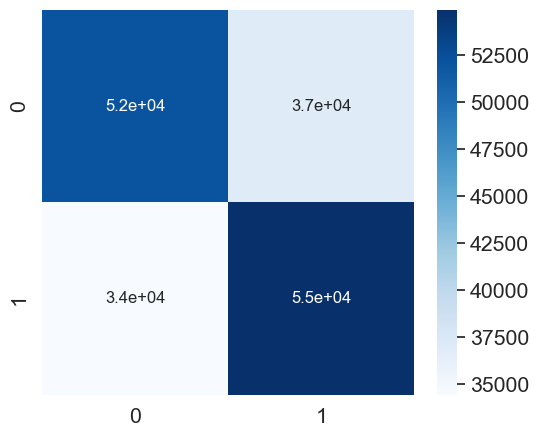

In [49]:
# Matriz de confusión
data=confusion_matrix(y_test, y_predict)

print("---Matriz de confusión---")
plt.figure(figsize = (6,5))
sns.set_theme(font_scale=1.4)
sns.heatmap(data, cmap="Blues", annot=True, annot_kws={"size": 12})

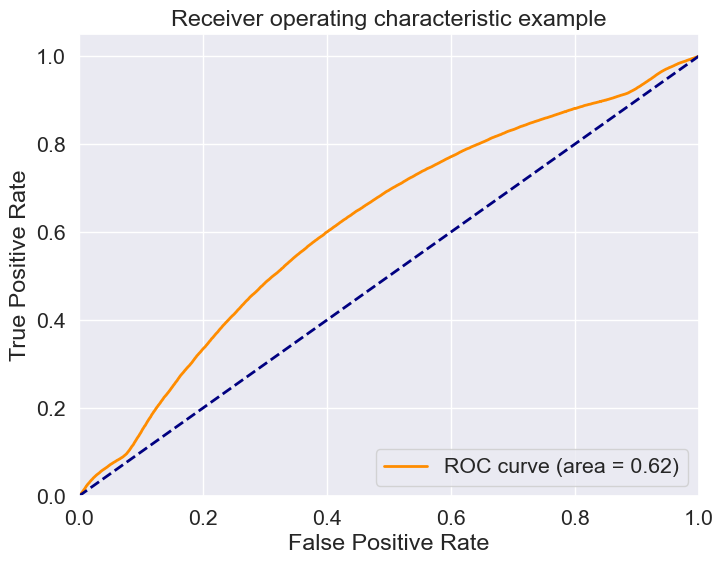

In [50]:
# Curva ROC y AUC
fpr, tpr, thresholds = roc_curve(y_test, predict_prob[:,1])
roc_auc=auc(fpr,tpr)

plt.figure(figsize = (8,6))
lw = 2
plt.plot(fpr, tpr, color='darkorange',
        lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)

plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

# 6. Interpretabilidad
+ Importancia de variables globales
+ Importancia de variables individuales con SHAP
+ SHAP Summary Plot

---Importancia global de las variables en el modelo---


<Axes: ylabel='predictor'>

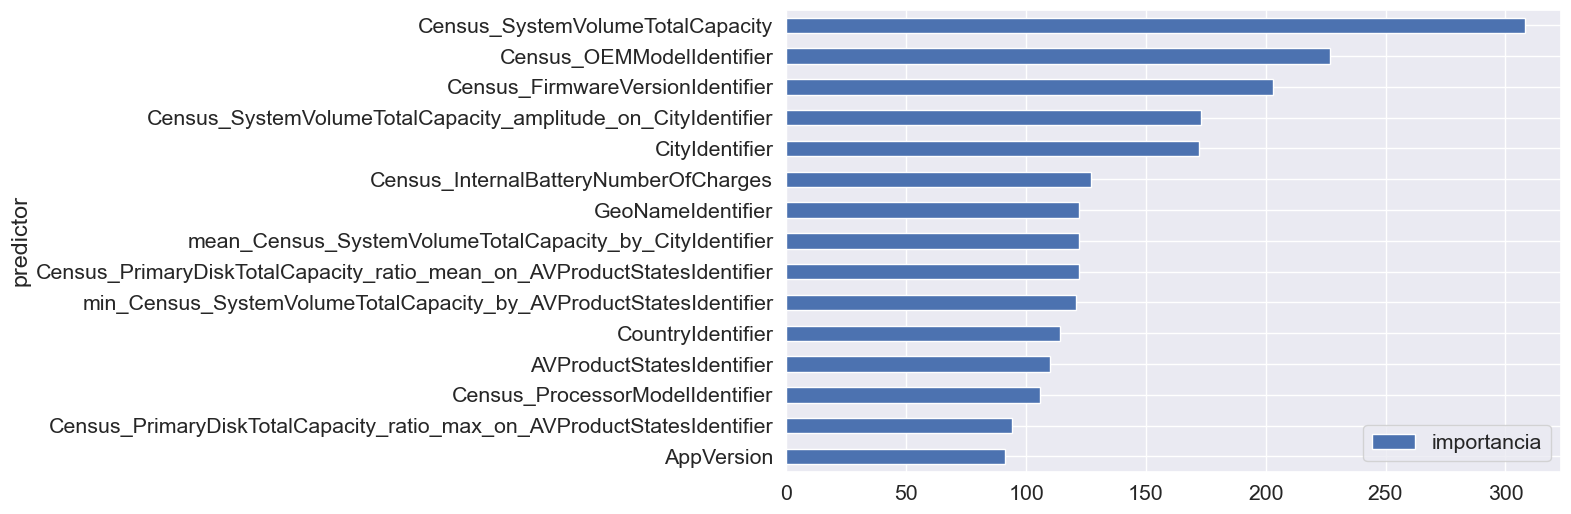

In [51]:
print("---Importancia global de las variables en el modelo---")

importancia_predictores = pd.DataFrame(
                            {'predictor': X_train.columns.tolist(),
                            'importancia': model.feature_importances_}
                            )
top_15_importantes = importancia_predictores.sort_values('importancia', ascending=False).head(15)

top_15_importantes.set_index('predictor').sort_values('importancia', ascending=True).plot(kind='barh', figsize=(10, 6))


In [52]:
explainer=shap.TreeExplainer(model)
shap_values=explainer.shap_values(X_test)

C:\Users\SumeriO\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\shap\explainers\_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')


---Importancia individual de variables con SHAP---


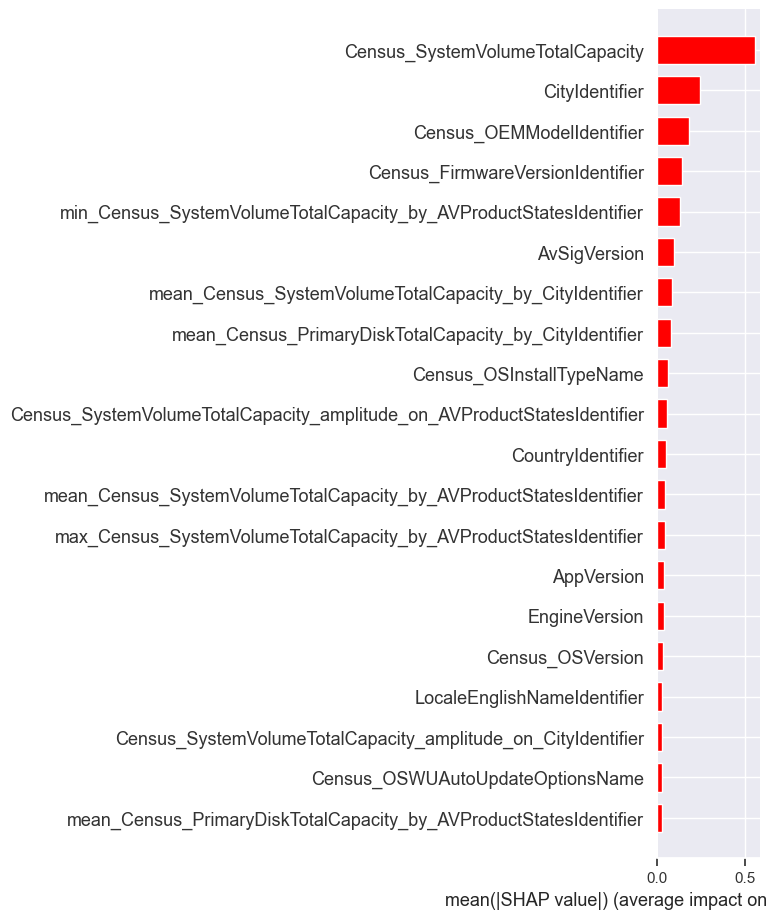

In [54]:
print("---Importancia individual de variables con SHAP---")
shap.summary_plot(shap_values, X_test, plot_type="bar", color='red')

---Summary Plot---


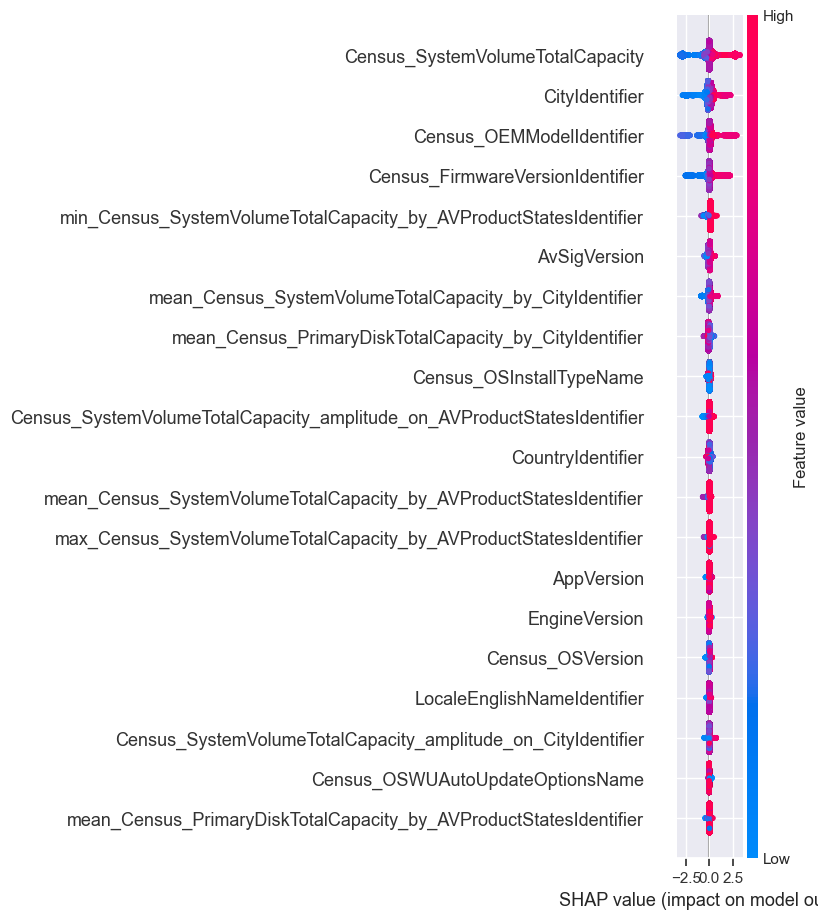

In [53]:
print("---Summary Plot---")
shap.summary_plot(shap_values, X_test)